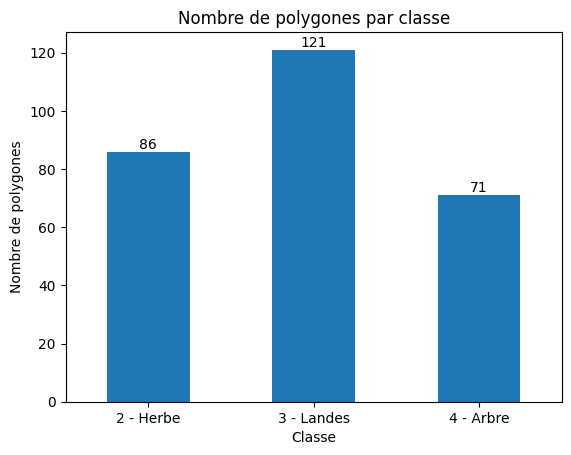

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Lire ton shapefile
gdf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")

# Dictionnaire de correspondance
map_strate = {
    1: "1 - Sol Nu",
    2: "2 - Herbe",
    3: "3 - Landes",
    4: "4 - Arbre"
}

# Création de la colonne
gdf["classe"] = gdf["strate"].map(map_strate)

# Comptage
counts = gdf['classe'].value_counts().sort_index()

# Graphique
fig, ax = plt.subplots()
bars = counts.plot(kind='bar', ax=ax)

ax.set_xlabel("Classe")
ax.set_ylabel("Nombre de polygones")
ax.set_title("Nombre de polygones par classe")

# Rotation horizontale
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Ajouter les étiquettes au-dessus des barres
for i, count in enumerate(counts):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()